<a href="https://colab.research.google.com/github/jKyuery/medical-dataset-analysis/blob/master/cnn_btd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages 
!pip install tensorflow visualkeras tensorflow_addons keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 24.0 MB/s 
     |████████████████████████████████| 989 kB 41.0 MB/s 


In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import os
import itertools
import cv2 
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from keras_preprocessing.image import load_img
from keras import layers
from keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# General parameters
epoch = 15
pic_size = 240
np.random.seed(45)
tf.random.set_seed(45)

In [5]:
# Load in the dataset
folder_path = '/content/drive/MyDrive/archive'
no_pics = os.listdir(folder_path + '/no')
yes_pics = os.listdir(folder_path + '/yes')
dataset = []
label = []

for image in no_pics:
  img = cv2.imread(folder_path + '/no/' + image)
  img = Image.fromarray(img, 'RGB')
  img = img.resize((240, 240))
  dataset.append(np.array(img))
  label.append(0)

for image in yes_pics:
  img = cv2.imread(folder_path + '/yes/' + image)
  img = Image.fromarray(img, 'RGB')
  img = img.resize((240, 240))
  dataset.append(np.array(img))
  label.append(1)

In [6]:
dataset = np.array(dataset)
label = np.array(label)
print(dataset.shape, label.shape)

(253, 240, 240, 3) (253,)


In [7]:
# Train test split 8:2
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, shuffle = True, random_state=45)
y_train

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1])

In [8]:
def plot_state(state):
  plt.figure(figsize= (12,12))
  for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path + '/' + state + '/' + os.listdir(folder_path + '/' + state)[i], target_size=(pic_size, pic_size))
    plt.imshow(img)
    plt.show()

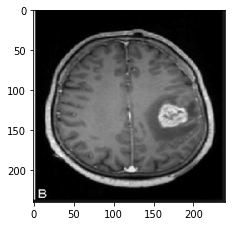

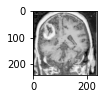

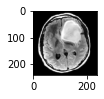

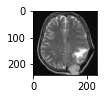

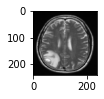

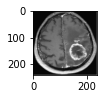

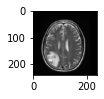

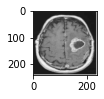

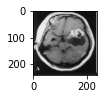

In [9]:
plot_state('yes')

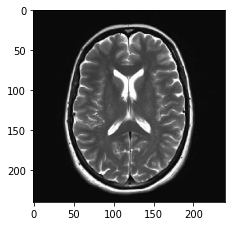

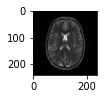

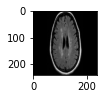

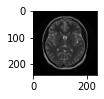

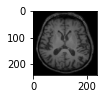

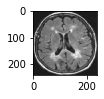

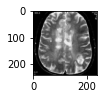

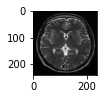

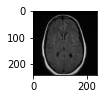

In [10]:
plot_state('no')

In [11]:
# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'valid', input_shape = (pic_size, pic_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'valid', input_shape = (pic_size, pic_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), bias_regularizer=regularizers.L2(1e-2),activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [12]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                4

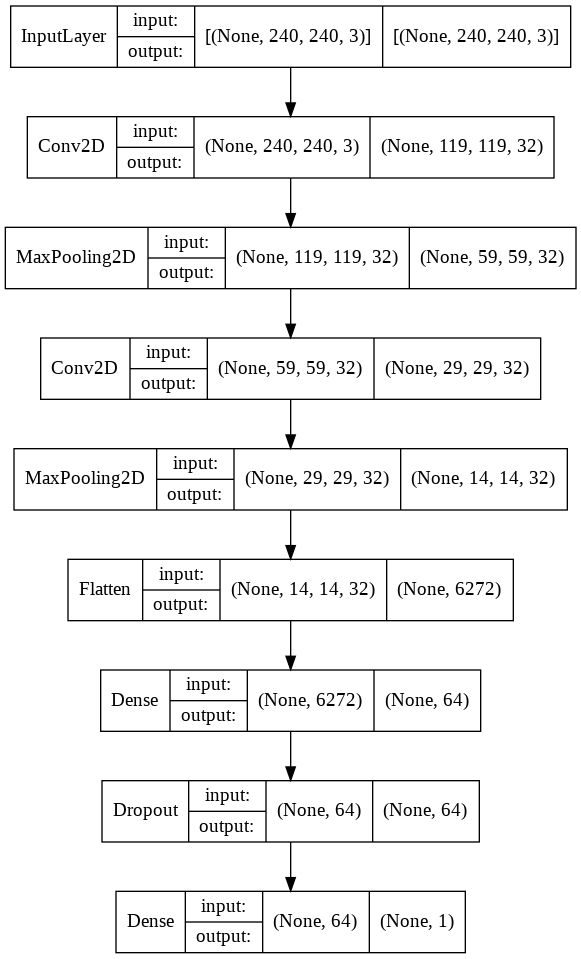

In [13]:
# Plot Model
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False)

In [14]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train), y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.3289473684210527, 1: 0.8015873015873016}

In [15]:
history = model.fit(x_train, y_train, epochs = 100, class_weight=class_weights, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 338ms/step - loss: 22.8059 - accuracy: 0.4802 - val_loss: 6.2597 - val_accuracy: 0.6275
Epoch 2/100
7/7 [==============================] - 2s 301ms/step - loss: 6.0886 - accuracy: 0.6733 - val_loss: 5.8259 - val_accuracy: 0.6667
Epoch 3/100
7/7 [==============================] - 2s 293ms/step - loss: 5.6326 - accuracy: 0.7030 - val_loss: 5.2705 - val_accuracy: 0.7451
Epoch 4/100
7/7 [==============================] - 2s 293ms/step - loss: 5.1809 - accuracy: 0.6683 - val_loss: 5.0125 - val_accuracy: 0.6863
Epoch 5/100
7/7 [==============================] - 2s 289ms/step - loss: 4.9510 - accuracy: 0.6782 - val_loss: 4.7897 - val_accuracy: 0.8039
Epoch 6/100
7/7 [==============================] - 2s 288ms/step - loss: 4.7912 - accuracy: 0.6733 - val_loss: 4.6195 - val_accuracy: 0.8039
Epoch 7/100
7/7 [==============================] - 2s 295ms/step - loss: 4.6056 - accuracy: 0.7079 - val_loss: 4.4741 - val_accuracy: 0.7843
Epoch 8/100


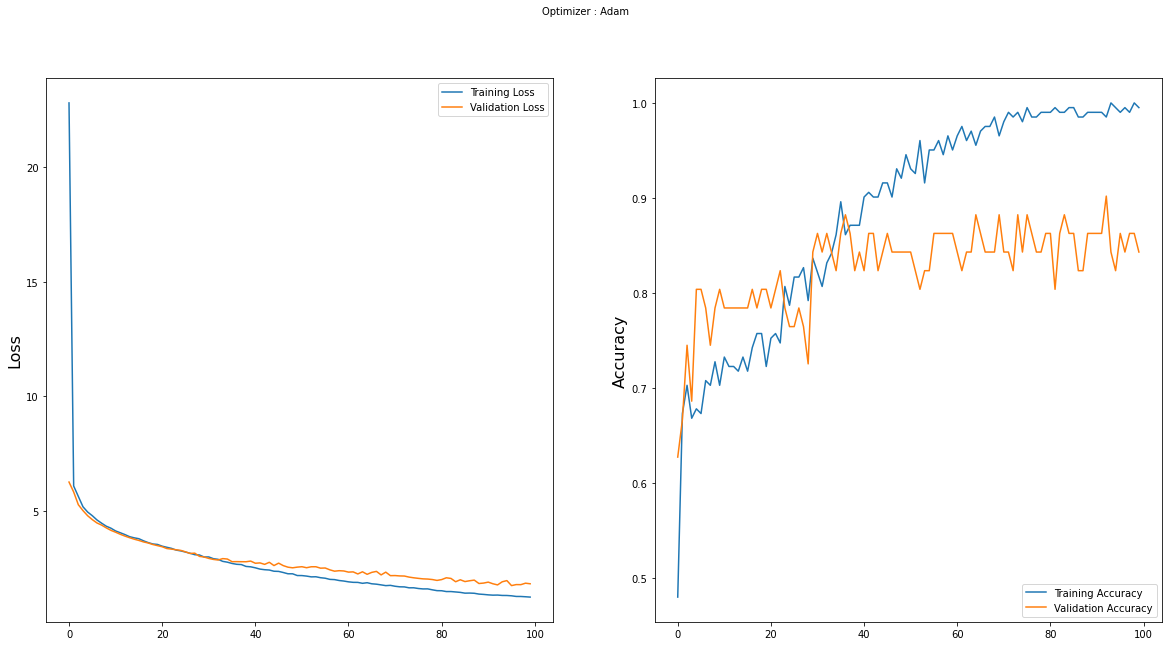

In [16]:
# Model Evaluation
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Evaluate
result = model.evaluate(x_test, y_test)
print("Model accuracy: {}%".format(round(result[1]* 100, 2)))

2/2 [==============================] - 0s 65ms/step - loss: 1.8202 - accuracy: 0.8431
Model accuracy: 84.31%


In [18]:
# Compute predictions
pred = model.predict(x_test)
y_pred = []
for i in pred:
  if i >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [19]:
# Custom function to plot confusion matrix
def plot_conf_matrix(cm, classes, title = 'Confusion Matrix', cmap = plt.cm.Blues):
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(10,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

<Figure size 432x288 with 0 Axes>

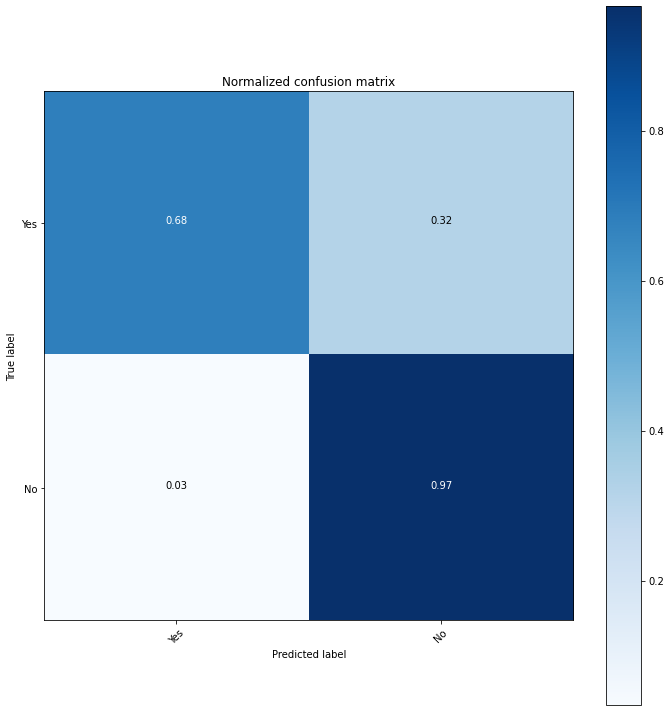

In [20]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_conf_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()